In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkContext, SparkConf

In [3]:
conf = SparkConf().setMaster("yarn").setAppName("Clustering")

In [4]:
sc = SparkContext.getOrCreate (conf = conf)
sc.getConf().getAll()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[('spark.app.id', 'application_1671345986273_0008'),
 ('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'master'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY

In [5]:
import seaborn as sns
import re
import csv
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib  import cm
import numpy as np

In [6]:
createType = "csv_read_chunk"
database = "final_database"

## 1. Perform data preprocessing steps.

In [7]:
wholdRDD = None

# if createType == "csv_read_all":
#     data = []
#     with open('{}.csv'.format(database), 'r') as file:
#         reader = csv.reader(file)
#         for row in reader:
#             data.append(tuple(row))
#     columns = data[0]
#     data = data[1:]
#     wholeRDD = sc.parallelize(data, 20)

if createType == "csv_read_chunk":
    rdd = sc.textFile("hdfs://master:9000/data/{}.csv".format(database), 20)
    wholeRDD = rdd.mapPartitions(lambda x: csv.reader(x))
    columns = wholeRDD.first()
    wholeRDD = wholeRDD.filter(lambda x: x[0] != 'Country')
else:
    print("Can not read data")

In [8]:
'''
Dataset has many columns which is inconvenient to index value. I extract the columns (list of attributes)
'''
print(columns)

['Country', 'Uri', 'Popularity', 'Title', 'Artist', 'Album/Single', 'Genre', 'Artist_followers', 'Explicit', 'Album', 'Release_date', 'Track_number', 'Tracks_in_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acoustics', 'instrumentalness', 'liveliness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'Genre_new', 'Days_since_release', 'Released_after_2017', 'Explicit_false', 'Explicit_true', 'album', 'compilation', 'single', 'bolero', 'boy band', 'country', 'dance/electronic', 'else', 'funk', 'hip hop', 'house', 'indie', 'jazz', 'k-pop', 'latin', 'metal', 'opm', 'pop', 'r&b/soul', 'rap', 'reggae', 'reggaeton', 'rock', 'trap', 'syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing', 'afinn', 'nrc', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'negative', 'positive', 'n_words', 'anger_norm', 'anticipation_norm', 'disgust_norm', 'fear_norm', 'joy_norm', 'sadness_norm', 'surprise_norm', 'trust_norm', 

Firstly, This dataset actually includes a lot of one-hot encoding vectors from category attributes like Country, Explicit, Genre, etc...

Secondly, there are many attributes having missing values (syuzhet_norm, syuzhet, bing, etc). It's reasonable to drop these columns

In [9]:
wholeRDD = wholeRDD.map(lambda line: line[:55] + line[112:])
columns = columns[:55] + columns[112:] 

In [10]:
c = { attr : idx  for idx, attr in enumerate(columns) }

In [11]:
print("Number of columns = ", len(c))

Number of columns =  94


In [12]:
c

{'Country': 0,
 'Uri': 1,
 'Popularity': 2,
 'Title': 3,
 'Artist': 4,
 'Album/Single': 5,
 'Genre': 6,
 'Artist_followers': 7,
 'Explicit': 8,
 'Album': 9,
 'Release_date': 10,
 'Track_number': 11,
 'Tracks_in_album': 12,
 'danceability': 13,
 'energy': 14,
 'key': 15,
 'loudness': 16,
 'mode': 17,
 'speechiness': 18,
 'acoustics': 19,
 'instrumentalness': 20,
 'liveliness': 21,
 'valence': 22,
 'tempo': 23,
 'duration_ms': 24,
 'time_signature': 25,
 'Genre_new': 26,
 'Days_since_release': 27,
 'Released_after_2017': 28,
 'Explicit_false': 29,
 'Explicit_true': 30,
 'album': 31,
 'compilation': 32,
 'single': 33,
 'bolero': 34,
 'boy band': 35,
 'country': 36,
 'dance/electronic': 37,
 'else': 38,
 'funk': 39,
 'hip hop': 40,
 'house': 41,
 'indie': 42,
 'jazz': 43,
 'k-pop': 44,
 'latin': 45,
 'metal': 46,
 'opm': 47,
 'pop': 48,
 'r&b/soul': 49,
 'rap': 50,
 'reggae': 51,
 'reggaeton': 52,
 'rock': 53,
 'trap': 54,
 'Argentina': 55,
 'Australia': 56,
 'Austria': 57,
 'Belgium': 58,

In [13]:
print("The number of tracks = " , wholeRDD.count())

The number of tracks =  170633


In [14]:
'''
Columns which's not parsable to numeric value
'''
string_cols = [ 'Country', 'Uri', 'Title', 'Artist', 'Album/Single', 'Genre', 
               'Explicit', 'Album', 'Release_date', 'Genre_new', 'Cluster' ]

In [15]:
'''
Columns which's parsable to numeric value
'''
numeric_cols = [ i for i in columns if i not in string_cols ]

In [16]:
print("String cols : ", string_cols)
print("\n")
print("Numeric cols : ", numeric_cols)

String cols :  ['Country', 'Uri', 'Title', 'Artist', 'Album/Single', 'Genre', 'Explicit', 'Album', 'Release_date', 'Genre_new', 'Cluster']


Numeric cols :  ['Popularity', 'Artist_followers', 'Track_number', 'Tracks_in_album', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acoustics', 'instrumentalness', 'liveliness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'Days_since_release', 'Released_after_2017', 'Explicit_false', 'Explicit_true', 'album', 'compilation', 'single', 'bolero', 'boy band', 'country', 'dance/electronic', 'else', 'funk', 'hip hop', 'house', 'indie', 'jazz', 'k-pop', 'latin', 'metal', 'opm', 'pop', 'r&b/soul', 'rap', 'reggae', 'reggaeton', 'rock', 'trap', 'Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Denmark', 'Ecuador', 'Finland', 'France', 'Germany', 'Global', 'Indonesia', 'Ireland', 'Italy', 'Malaysia', 'Mexico', 'Netherlands', 'New Zealand', 'Norway', 'Peru', 'Philippines', '

In [17]:
def add2Tuple(a,b):
    return tuple([ a[idx] + b[idx] for idx in range(len(a)) ])

def checkIsFloat(number):
    try:
        float(number)
        return True
    except:
        return False

In [18]:
def checkValidLine(line):
    check = True
    for col in numeric_cols:
        check = check and checkIsFloat(line[c[col]])
    
    if check == False:
        return check
    
    for col in string_cols:
        check = check and line[c[col]] != ''
    return check
    

Our dataset has many numerical columns which potentialy include empty values or invalid values (for example "abc" can not convert to number). We will check if a line is valid and apply filter to include valid line

In [19]:
lineRDD = wholeRDD.filter(lambda line: checkValidLine(line))

In [20]:
print("The number of pre-processed tracks = " , lineRDD.count())

The number of pre-processed tracks =  167356


In [21]:
def processNumeric(line):
    _line = list(line)
    for col in numeric_cols:
        _line[c[col]] = float(_line[c[col]])
    return tuple(_line)

In [22]:
processNumeric(lineRDD.take(1)[0])

('Global',
 'https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk',
 31833.95,
 'adan y eva',
 'Paulo Londra',
 'single',
 'argentine hip hop',
 11427104.0,
 'False',
 'Adan y Eva',
 '2018-11-05',
 1.0,
 1.0,
 0.767,
 0.7090000000000001,
 1.0,
 -4.47,
 1.0,
 0.336,
 0.32299999999999995,
 0.0,
 0.0676,
 0.72,
 171.993,
 258639.0,
 4.0,
 'hip hop',
 740.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 10.0,
 1.0,
 1.0,
 'global')

In [23]:
'''
- Process numerical values
'''
lineRDD = lineRDD.map(lambda line: processNumeric(line))

In [24]:
lineRDD.count()

167356

## 2. Find out the number of unique songs in the dataset.

For convenience in data processing, I create a sub-RDD from wholeRDD which contains the first 11 columns. The rest is only
used for building clustering model

A song is unique by its artist and title. We map rdd to ((title, artist), 1) and reduce by key, then count numbers of instances


In [25]:
print("Number of unique songs in the dataset = ", lineRDD.map(lambda line: ((line[3], line[4]) , 1)).reduceByKey(lambda a,b : a + b).count())

Number of unique songs in the dataset =  54905


## 3. Plot a bar chart to visualize top 10 popular artists for all countries.

Popularity in rdd has datatype as string, we need to convert to numerical type.

Map to (Artist, Popularity) and perform reduce method. Then we need to sort rdd in descending order, and take top 10 values

In [26]:
top10Artist = lineRDD.map(lambda line: (line[4], float(line[2]))).reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], ascending = False).take(10)
print(top10Artist)

[('Ed Sheeran', 14425282.900000004), ('Billie Eilish', 8643470.450000005), ('Dua Lipa', 8149820.700000004), ('Drake', 8149430.5), ('Ariana Grande', 8124747.349999999), ('Post Malone', 7895982.400000006), ('XXXTENTACION', 6250533.65), ('Lewis Capaldi', 5155235.250000002), ('The Weeknd', 5143012.25), ('Imagine Dragons', 5009539.549999999)]


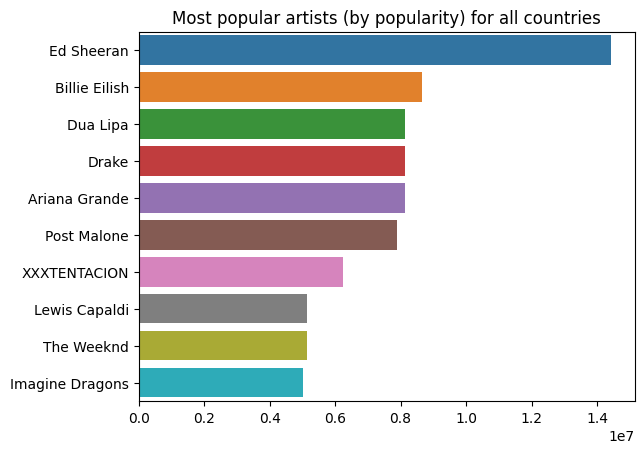

In [27]:
plotTop10 = {}
plotTop10['Artist'] = [item[0] for item in top10Artist]
plotTop10['Count'] = [item[1] for item in top10Artist]

sns.barplot(data=plotTop10, y='Artist', x='Count').set_title('Most popular artists (by popularity) for all countries');

## 4. Show the most popular song (based on its popularity) for each decade.

First, we need to group lineRDD by (decade, title, artist) with values popularity. Decade is extracted from year in Release_date. Apply reduceByKey on new rdd with the lambda function to get max (compare current line with previous one)

In [28]:
from datetime import datetime
def get_decade(datetime_str):
    datetime_object = datetime_str.split("-")
    year = int(datetime_object[0])
    return year - year % 10

In [29]:
A = lineRDD.map(lambda line: ((get_decade(line[10]), line[3], line[4]), float(line[2])))

In [30]:
A.take(10)

[((2010, 'adan y eva', 'Paulo Londra'), 31833.95),
 ((2010, 'adan y eva', 'Paulo Londra'), 8.0),
 ((2010, 'adan y eva', 'Paulo Londra'), 76924.4),
 ((2010, 'adan y eva', 'Paulo Londra'), 849.6000000000001),
 ((2010, 'adan y eva', 'Paulo Londra'), 20739.1),
 ((2010, 'adan y eva', 'Paulo Londra'), 60264.19999999997),
 ((2010, 'adan y eva', 'Paulo Londra'), 60131.15000000014),
 ((2010, 'adan y eva', 'Paulo Londra'), 64081.30000000009),
 ((2010, 'adan y eva', 'Paulo Londra'), 208.0),
 ((2010, 'adan y eva', 'Paulo Londra'), 75636.9)]

In [31]:
unique_group = A.reduceByKey(lambda a,b : a + b)

In [32]:
unique_group.take(4)

[((2010, 'betrayed', 'Lil Xan'), 162585.80000000005),
 ((2010, 'flash pose', 'Pabllo Vittar - Charli XCX'), 2875.3000000000015),
 ((2010,
   'white christmas - spotify singles - holiday, recorded at air studios, london',
   'George Ezra'),
  7946.3499999999985),
 ((2020, 'yikes', 'Nicki Minaj'), 3220.3)]

In [33]:
max_by_group = unique_group.map(lambda x: (x[0][0], x)).reduceByKey(lambda x1, x2: max(x1, x2, key=lambda x: x[-1]))
max_by_group.map(lambda x: (x[1][0][0], x[1][0][1], x[1][0][2], x[1][1])).collect()

[(2020, 'blinding lights', 'The Weeknd', 1894466.8000000003),
 (1980, 'last christmas', 'Wham!', 552997.2499999999),
 (2000, 'the scientist', 'Coldplay', 454409.69999999995),
 (1960,
  'its the most wonderful time of the year',
  'Andy Williams',
  188815.39999999997),
 (1940,
  'white christmas',
  'Bing Crosby - Ken Darby Singers - John Scott Trotter & His Orchestra',
  127754.15),
 (1920, 'when you wish upon a star', 'Cliff Edwards', 22.4),
 (1900, 'roll out the barrel', 'The Beverley Sisters', 109.65),
 (2010, 'shape of you', 'Ed Sheeran', 5732932.350000004),
 (1970, 'bohemian rhapsody - remastered 2011', 'Queen', 763373.6500000001),
 (1990, 'all i want for christmas is you', 'Mariah Carey', 788281.7999999998),
 (1950, 'jingle bell rock', 'Bobby Helms', 98426.19999999997),
 (1930,
  'moonlight serenade - 2005 remastered version',
  'Glenn Miller',
  101.15)]

## 5. Visualize the changing of music over the decades.


In [34]:
change_rdd = lineRDD.map(lambda line: (get_decade(line[10]), (float(line[c['danceability']]), float(line[c['energy']]), float(line[c['instrumentalness']]),
                                        float(line[c['valence']]), float(line[c['liveliness']]), float(line[c['acoustics']]),float(line[c['speechiness']]), 1)))

In [35]:
change_music_summary = change_rdd.reduceByKey(lambda a,b: add2Tuple(a,b))

In [36]:
change_music_summary_list = change_music_summary.map(lambda x: (x[0], (x[1][0]/x[1][7],x[1][1]/x[1][7],x[1][2]/x[1][7],x[1][3]/x[1][7],
                                                                      x[1][4]/x[1][7],x[1][5]/x[1][7],x[1][6]/x[1][7]))).collect()

In [37]:
change_music_summary_list

[(2020,
  (0.6956963899031595,
   0.6399753103667248,
   0.014767369088109224,
   0.4982401555802501,
   0.17735656135894606,
   0.23159966248229874,
   0.14394171455786633)),
 (2000,
  (0.58753543876567,
   0.6753296552555457,
   0.019118004467213127,
   0.5118616441658632,
   0.19906661041465767,
   0.264569643370299,
   0.07104640790742524)),
 (1980,
  (0.6217126640926645,
   0.6232270270270271,
   0.02694345149034749,
   0.6683579922779925,
   0.17900239382239375,
   0.28490186640926635,
   0.05110687258687259)),
 (1940,
  (0.3727567567567568,
   0.18967567567567567,
   0.17292231891891885,
   0.394527027027027,
   0.2624054054054054,
   0.7170540540540539,
   0.047789189189189195)),
 (1960,
  (0.567344,
   0.4882298,
   0.0040413368000000015,
   0.7228804000000002,
   0.16513939999999996,
   0.49359361999999996,
   0.04647979999999999)),
 (1920, (0.227, 0.446, 0.00912, 0.119, 0.322, 0.851, 0.032)),
 (1900,
  (0.5489999999999999,
   0.324,
   1.13e-06,
   0.589,
   0.48700000000000

In [38]:
music_features = {"Year" : [], "Characteristic" : [], "Val": []}
characteristics = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'acoustics', 'speechiness']
for year_music in change_music_summary_list:
    (year, list_mean) = year_music
    for idx, val in enumerate(list_mean):
        music_features["Year"].append(year)
        music_features["Characteristic"].append(characteristics[idx])
        music_features["Val"].append(val)

In [39]:
df = pd.DataFrame(music_features, columns = ["Year", "Characteristic", "Val"])

In [40]:
df

,Year,Characteristic,Val
0,2020,danceability,0.695696
1,2020,energy,0.639975
2,2020,instrumentalness,0.014767
3,2020,valence,0.498240
4,2020,liveliness,0.177357
...,...,...,...
79,1930,instrumentalness,0.317000
80,1930,valence,0.224000
81,1930,liveliness,0.103000
82,1930,acoustics,0.896000


Text(0.5, 1.0, 'Song Characteristics Over the Decades')

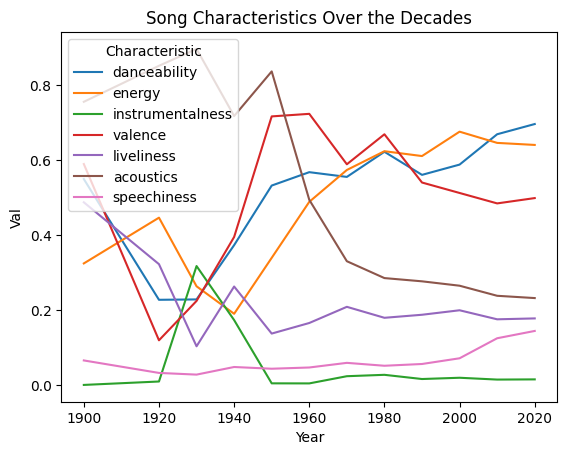

In [41]:
sns.lineplot(data=df, x="Year", y="Val", hue="Characteristic").set_title('Song Characteristics Over the Decades')

## 6. You are about to build a song recommendation system.


In [42]:
'''
As in lab assignment, we only filter metal and hip-hop.
'''
cluster_RDD = lineRDD.filter(lambda line: line[c["Genre_new"]] == 'metal' or line[c["Genre_new"]] == 'hip hop')

In [43]:
print("Number of tracks has genre hip hop or metal = ", cluster_RDD.count())

Number of tracks has genre hip hop or metal =  37940


Now it's time to encode lineRDD so clustering can work on it. All values need to be encoded into numerical form:
- Categorical data (Country, Genre, Explicit, etc..) will be transformed to number by label encoders (0,1,2,3,...)

In [44]:
'''
- Process categorical values
'''
categorical_cols = ['Country',
 'Album/Single',
 'Genre',
 'Explicit',
 'Genre_new',
 'Cluster']

In [45]:
_map = {}
for col in categorical_cols:
    _list = cluster_RDD.map(lambda line: (line[c[col]], 1)).reduceByKey(lambda a,b: a+b).keys().collect()
    _map[col] = _list

In [46]:
for key in _map :
    _labels_map = { val : idx  for idx, val in enumerate(_map[key])  }
    _map[key] = _labels_map

In [47]:
_map

{'Country': {'Belgium': 0,
  'Denmark': 1,
  'Finland': 2,
  'Poland': 3,
  'Global': 4,
  'Ecuador': 5,
  'Peru': 6,
  'Portugal': 7,
  'Austria': 8,
  'Taiwan': 9,
  'Colombia': 10,
  'Indonesia': 11,
  'USA': 12,
  'Switzerland': 13,
  'Canada': 14,
  'Germany': 15,
  'New Zealand': 16,
  'Australia': 17,
  'Singapore': 18,
  'Turkey': 19,
  'Chile': 20,
  'UK': 21,
  'Costa Rica': 22,
  'Argentina': 23,
  'Sweden': 24,
  'France': 25,
  'Philippines': 26,
  'Brazil': 27,
  'Malaysia': 28,
  'Netherlands': 29,
  'Norway': 30,
  'Mexico': 31,
  'Spain': 32,
  'Ireland': 33,
  'Italy': 34},
 'Album/Single': {'compilation': 0, 'single': 1, 'album': 2},
 'Genre': {'manchester hip hop': 0,
  'metal': 1,
  'taiwan hip hop': 2,
  'serbian hip hop': 3,
  'conscious hip hop': 4,
  'turkish hip hop': 5,
  'spanish hip hop': 6,
  'finnish death metal': 7,
  'southern hip hop': 8,
  'singaporean hip hop': 9,
  'alternative metal': 10,
  'indonesian hip hop': 11,
  'argentine heavy metal': 12,
 

In [48]:
'''
Label encoding dataset on categories 'Country', 'Album/Single', 'Genre', 'Explicit', 'Genre_new', 'Cluster'
'''
def processCategory(line):
    _line = list(line)
    for col in _map:
        idx_line = c[col]
        _line[idx_line] = _map[col][_line[idx_line]]
    return tuple(_line)

cluster_RDD = cluster_RDD.map(lambda line: processCategory(line))

In [49]:
'''
We need to remove inessential cols for building clustering: Release_date, Title, Artist,... They now are in string format.
The rest is in numerical format
'''
def get_vector_line(x):
    return tuple([val for val in list(x) if not isinstance(val, str)])

cluster_vector_RDD = cluster_RDD.map(lambda x: (x[1], get_vector_line(x)))

In [50]:
print("Number of training size for clustering = ", cluster_vector_RDD.count())

Number of training size for clustering =  37940


In [51]:
print("Size of feature vector = ", len(cluster_vector_RDD.take(1)[0][1]))

Size of feature vector =  89


In this clustering model, we use danceability and enery because they might tell something about how different the groups are.

In [52]:
popu_genre_rdd = cluster_vector_RDD.map(lambda line: (line[0], (line[1][8], line[1][9]))) # danceability, energy

In [53]:
popu_genre_rdd.take(2)

[('https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk',
  (0.767, 0.7090000000000001)),
 ('https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk',
  (0.767, 0.7090000000000001))]

In [54]:
def get_max_rdd(rdd):
    return rdd.map(lambda x: x[1]).reduce(lambda a, b: (max(a[0], b[0]), max(a[1],b[1])))

def get_min_rdd(rdd):
    return rdd.map(lambda x: x[1]).reduce(lambda a, b: (min(a[0], b[0]), min(a[1],b[1])))

max_of_cols = get_max_rdd(popu_genre_rdd)
min_of_cols = get_min_rdd(popu_genre_rdd)
print(max_of_cols)
print(min_of_cols)

(0.98, 0.998)
(0.0628, 0.012)


In [55]:
'''
It's vital to scale data in a range. We scale it to [0, 1]
'''
def min_max_scaler(line):
    return tuple([(line[0]-min_of_cols[0])/(max_of_cols[0]-min_of_cols[0]), (line[1]-min_of_cols[1])/(max_of_cols[1]-min_of_cols[1])])

popu_genre_rdd = popu_genre_rdd.map(lambda line: (line[0], min_max_scaler(line[1])))

In [56]:
popu_genre_rdd.take(2)

[('https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk',
  (0.76777147841256, 0.706896551724138)),
 ('https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk',
  (0.76777147841256, 0.706896551724138))]

In [57]:
'''
We choose number of clusters = 2
We use takeSample() function to generate initial centroids
'''
num_of_clusters = 2
k_cluster = popu_genre_rdd.takeSample(False, num_of_clusters)

In [58]:
k_cluster = [(idx, x[1]) for idx, x in enumerate(k_cluster)]
print(k_cluster) # (label, vector)

[(0, (0.8702573048408199, 0.5618661257606491)), (1, (0.8440907108591366, 0.5821501014198782))]


In [59]:
# Add updatable label after each line of rdd
'''
In order to make it easy for updating centroid using reduceByKey, we use labels as key for each group.
Keys are updated until clusters are stabe
'''
default_label = -1
default_check = True
train_popu_genre_rdd = popu_genre_rdd.map(lambda line: (default_label, (line[0], line[1], default_check)))
print(train_popu_genre_rdd.take(2))

[(-1, ('https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk', (0.76777147841256, 0.706896551724138), True)), (-1, ('https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk', (0.76777147841256, 0.706896551724138), True))]


In [60]:
'''
Function to compute cosine similarity
'''
def cosine_similarity(vec1, vec2):
    if len(vec1) != len(vec2):
        return
    
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(vec1)):
        x = vec1[i]; y = vec2[i]
        sumxx += x * x
        sumyy += y * y
        sumxy += x * y
    return sumxy / math.sqrt(sumxx * sumyy)

In [61]:
# calculate cosine similarity of each line with 3 centroids
'''
line's format : (-1, ('https://open.spotify.com/track/1wLQwg0mloy3yXjL0jPE0N', (60.8, 6), True))
cluster's format : [(0, (9648.05, 11)), (1, (7040.1, 2)), (2, (839.5, 48))]
'''
k_update_cluster = k_cluster

def find_cluster_for_line(line):
    cosine_measure_list = [cosine_similarity(line[1][1], cluster[1]) for cluster in k_update_cluster]
    min_cosine = cosine_measure_list[0]
    min_idx = 0
    for idx, val in enumerate(cosine_measure_list):
        if val < min_cosine:
            min_cosine = val
            min_idx = idx
            
    return (min_idx, (line[1][0], line[1][1], min_idx != line[0]))

In [62]:
k_update_cluster

[(0, (0.8702573048408199, 0.5618661257606491)),
 (1, (0.8440907108591366, 0.5821501014198782))]

In [63]:
def calculate_sum_and_count(vec1, vec2):
    '''
    vec1: (vector1, 1)
    vec2: (vector2, 1)
    '''
    sum_point = add2Tuple(vec1[0], vec2[0])
    count_point = vec1[1] + vec2[1]
    return tuple([sum_point, count_point])

def avg_points(sum_point, count_point):
    return tuple([ float(i/count_point) for i in sum_point ])


In [64]:
def update_centroids(candidates):
    candidate_label = {val[0]: val[1] for val in candidates}
    for i in range(len(k_update_cluster)):
        k_update_cluster[i] = list(k_update_cluster[i])
        if k_update_cluster[i][0] in candidate_label:
            k_update_cluster[i][1] = candidate_label[k_update_cluster[i][0]] 
        
        k_update_cluster[i] = k_update_cluster[i]

In [65]:
is_stop = False
updated_popu_genre_rdd = train_popu_genre_rdd

while True:
    updated_popu_genre_rdd = updated_popu_genre_rdd.map(lambda line: find_cluster_for_line(line))    
    is_stop = updated_popu_genre_rdd.filter(lambda line: line[1][2] == True).isEmpty() is True
    
    if is_stop == True:
        break
    else:
        # update centroids by find average points
        temp_centroids = updated_popu_genre_rdd.map(lambda line: (line[0], (line[1][1], 1))).reduceByKey(lambda a,b : calculate_sum_and_count(a,b) ).collect()
        temp_centroids = [(p[0], avg_points(p[1][0], p[1][1])) for p in temp_centroids]        
        update_centroids(temp_centroids)

In [66]:
k_update_cluster

[[0, (0.6863010173233001, 0.6948864844923297)],
 [1, (0.8234034345105834, 0.45193381369188496)]]

In [67]:
cluster_0 = updated_popu_genre_rdd.filter(lambda x: x[0] == 0).collect()
cluster_1 = updated_popu_genre_rdd.filter(lambda x: x[0] == 1).collect()

## 7. Visualize the results you get from the clustering tasks


In [68]:
x = []
y = []
label = []
for cluster in [cluster_0, cluster_1]:
    for item in cluster:
        label.append(item[0])
        x.append(item[1][1][0])
        y.append(item[1][1][1])

In [69]:
centroid_x = []
centroid_y = []
for p in k_update_cluster:
    centroid_x.append(p[1][0])
    centroid_y.append(p[1][1])

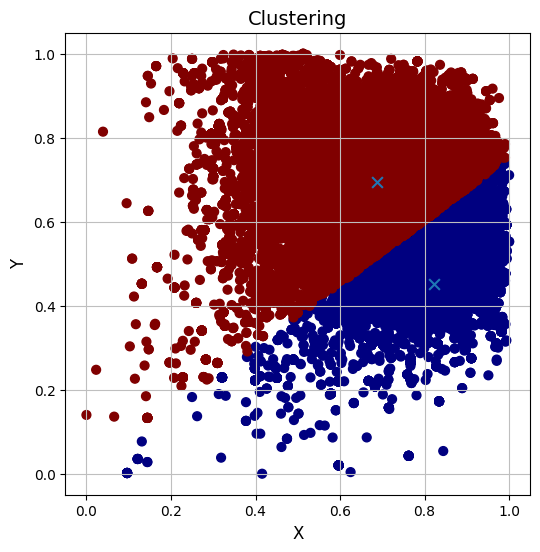

In [70]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.set_title("Clustering",fontsize=14)
ax.set_xlabel("X",fontsize=12)
ax.set_ylabel("Y",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

ax.scatter(x, y ,s=40,c=label, marker = 'o', cmap = cm.jet )
ax.scatter(centroid_x,centroid_y,s=60, marker = 'x', cmap = cm.jet )

plt.show()